https://androidkt.com/tensorflow-keras-unet-for-image-image-segmentation/

https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

https://arxiv.org/pdf/1505.04597.pdf


In [2]:
import tensorflow as tf
import os
import sys
 
import numpy as np
 
from tqdm import tqdm
from itertools import chain
 
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt

In [50]:
IMG_WIDTH = 400
IMG_HEIGHT = 400
IMG_CHANNELS = 3
 
IMAGE_DATA_PATH = 'training/images/'
MASK_DATA_PATH = 'training/groundtruth/'

SEED = 42
random.seed = SEED
np.random.seed = SEED

In [25]:
images_filenames = os.listdir(DATA_PATH)

In [51]:

 
X = np.zeros((len(images_filenames), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(images_filenames), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
 
for n, filename in tqdm(enumerate(images_filenames), total=len(images_filenames)):   
    img = imread(IMAGE_DATA_PATH + filename)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = imread(MASK_DATA_PATH + filename)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
    Y[n] = mask
 
x_train=X 
y_train=Y

100%|██████████| 100/100 [00:02<00:00, 38.19it/s]


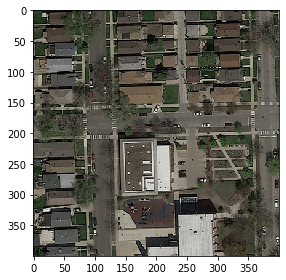

In [52]:
imshow(x_train[1])

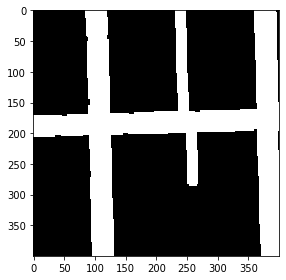

In [53]:
imshow(np.squeeze(y_train[1]))

In [54]:
# Build U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 400, 400, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 400, 400, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 400, 400, 16) 0           conv2d_19[0][0]                  
____________________________________________________________________________________________

In [55]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
 
callbacks = [
  #tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  tf.keras.callbacks.TensorBoard(log_dir='./logs'),
  cp_callback 
]
 
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=20,
                    callbacks=callbacks)
 

Train on 90 samples, validate on 10 samples
Epoch 1/20
80/90 [=========================>....] - ETA: 5s - loss: 0.6452 - accuracy: 0.6835 
Epoch 00001: saving model to training_1/cp.ckpt
90/90 [==============================] - 52s 572ms/sample - loss: 0.6293 - accuracy: 0.6994 - val_loss: 0.5385 - val_accuracy: 0.7703
Epoch 2/20
80/90 [=========================>....] - ETA: 5s - loss: 0.5804 - accuracy: 0.7503 
Epoch 00002: saving model to training_1/cp.ckpt
90/90 [==============================] - 50s 552ms/sample - loss: 0.5806 - accuracy: 0.7482 - val_loss: 0.5667 - val_accuracy: 0.7600
Epoch 3/20
80/90 [=========================>....] - ETA: 5s - loss: 0.5585 - accuracy: 0.7494 
Epoch 00003: saving model to training_1/cp.ckpt
90/90 [==============================] - 50s 553ms/sample - loss: 0.5644 - accuracy: 0.7450 - val_loss: 0.5671 - val_accuracy: 0.7555
Epoch 4/20
80/90 [=========================>....] - ETA: 5s - loss: 0.5420 - accuracy: 0.7411 
Epoch 00004: saving model to t

1/1 [==============================] - 0s 335ms/sample


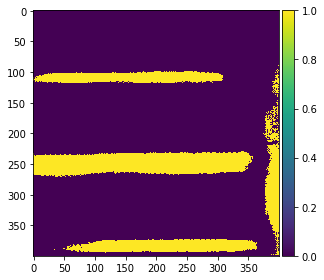

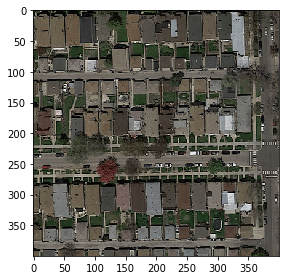

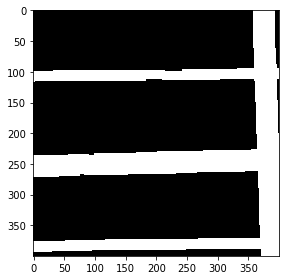

In [56]:

idx = 12#random.randint(0, len(x_train))
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)
 
predict = (predict > 0.5).astype(np.uint8)
 
imshow(np.squeeze(predict[0]))
plt.show()
 
imshow(x_train[idx])
 
plt.show()
imshow(np.squeeze(y_train[idx]))

In [107]:
def get_prediction(img):
    x=np.array(img)
    x=np.expand_dims(x, axis=0)
    predict = model.predict(x, verbose=1)
 
    predict = (predict > 0.5).astype(np.uint8)

    return np.squeeze(predict[0])

1/1 [==============================] - 0s 129ms/sample


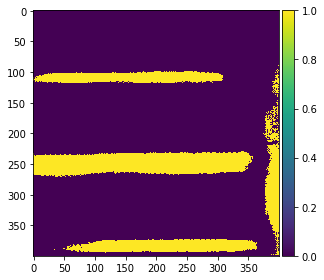

In [108]:
imshow(get_prediction(x_train[12]))

In [89]:
from PIL import Image

In [90]:
PIXEL_DEPTH=255
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)
    return rimg

In [109]:
print("Running prediction on submission set")
submission_data_dir = 'test_set_images/'
prediction_submission_dir = "predictions_submission/"
if not os.path.isdir(prediction_submission_dir):
    os.mkdir(prediction_submission_dir)
for i in range(1, 51):
    pimg = imread(submission_data_dir + f"test_{i}/test_{i}.png")[:,:,:IMG_CHANNELS]
    pimg = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        
    pimg = get_prediction(pimg)
    n_channels = len(pimg.shape)
    w = pimg.shape[0]
    h = pimg.shape[1]
    if n_channels == 3:
        cimg = pimg
    else:
        cimg = np.zeros((w, h, 3), dtype=np.uint8)
        pimg8 = img_float_to_uint8(pimg)
        cimg[:, :, 0] = pimg8
        cimg[:, :, 1] = pimg8
        cimg[:, :, 2] = pimg8
    
    Image.fromarray(cimg).save(prediction_submission_dir + f"gt_{i}.png")

Running prediction on submission set
1/1 [==============================] - 0s 159ms/sample


Running prediction on submission set
1/1 [==============================] - 0s 126ms/sample


/home/bastien/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


ValueError: could not broadcast input array from shape (400,400,1) into shape (1,400)